Generacion de metrica para todos los Frame del video

Frame con maximo enfoque es: 111, LAP1 = 25096817.00000


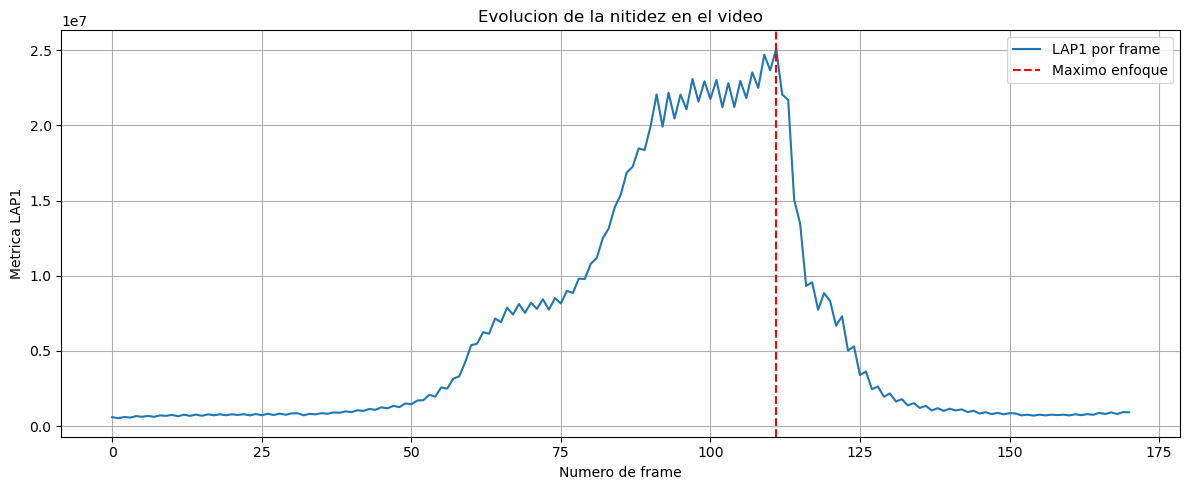

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Funcion para calcular la metrica LAP1
def calcular_lap1(imagen):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gris, cv2.CV_64F)
    energia = np.sum(np.square(lap))
    return energia


video = cv2.VideoCapture('focus_video.mov')
fms = []
frames = []
#Para cada frame hago el calculo de la metrica
while True:
    ret, frame = video.read()
    if not ret:
        break
    fm = calcular_lap1(frame)
    fms.append(fm)
    frames.append(frame)

video.release()

#busco el frame con maximo enfoque
max_index = np.argmax(fms)
print(f"Frame con maximo enfoque es: {max_index}, LAP1 = {fms[max_index]:.5f}")

# Grafico
plt.figure(figsize=(12, 5))
plt.plot(fms, label='LAP1 por frame')
plt.axvline(x=max_index, color='r', linestyle='--', label='Maximo enfoque')
plt.xlabel('Numero de frame')
plt.ylabel('Metrica LAP1')
plt.title('Evolucion de la nitidez en el video')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("evolucion_enfoque_frema_x_frame_LAP1.png")
plt.show()


Medicion sobre una ROI ubicada en el centro del frame, area del ROI entre 5 o 10 % del area total del frame y generacion de video con la ROI marcada y color segun foco

Frame con maximo enfoque (ROI): 111, FM = 0.35841


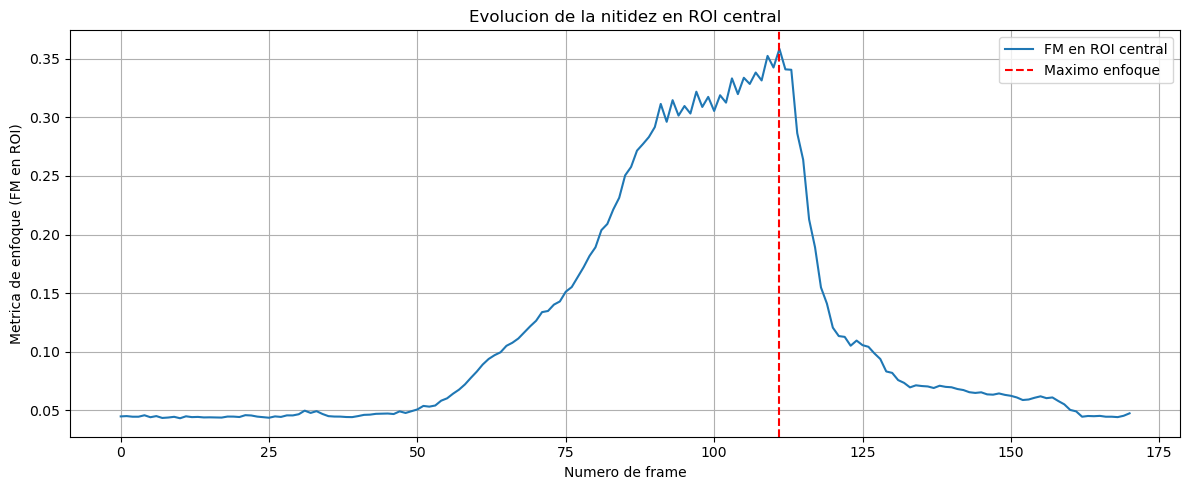

Video generado: output_roi_focus.avi


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calcular_lap1(imagen):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gris, cv2.CV_64F)
    energia = np.sum(np.square(lap))
    return energia

def extraer_roi_central(frame, porcentaje=0.10):
    h, w = frame.shape[:2]
    factor = np.sqrt(porcentaje)
    roi_h = int(h * factor)
    roi_w = int(w * factor)
    start_y = h // 2 - roi_h // 2
    start_x = w // 2 - roi_w // 2
    roi = frame[start_y:start_y + roi_h, start_x:start_x + roi_w]
    return roi


video = cv2.VideoCapture('focus_video.mov')
fms = []
frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break
    roi = extraer_roi_central(frame, porcentaje=0.10)
    fm = calcular_lap1(roi)
    fms.append(fm)
    frames.append(frame)

video.release()

#Frame con maximo enfoque en la ROI
max_index = np.argmax(fms)
print(f"Frame con maximo enfoque (ROI): {max_index}, LAP1 = {fms[max_index]:.5f}")

# Grafico
plt.figure(figsize=(12, 5))
plt.plot(fms, label='LAP1 en ROI central')
plt.axvline(x=max_index, color='r', linestyle='--', label='Maximo enfoque')
plt.xlabel('Numero de frame')
plt.ylabel('Metrica de enfoque (LAP1 en ROI)')
plt.title('Evolucion de la nitidez en ROI central')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("evolucion_enfoque_roi_LAP1.png")
plt.show()


#Creacion del video con la ROI marcada

output = cv2.VideoWriter(
    'output_roi_focus_LAP1.avi',
    cv2.VideoWriter_fourcc(*'XVID'),30,(frames[0].shape[1], frames[0].shape[0])
)

for i, frame in enumerate(frames):
    # Extraer ROI central del frame
    h, w = frame.shape[:2]
    factor = np.sqrt(0.10)
    roi_h = int(h * factor)
    roi_w = int(w * factor)
    start_y = h // 2 - roi_h // 2
    start_x = w // 2 - roi_w // 2

    # Color verde si esta en foco sino rojo 
    color = (0, 255, 0) if i == max_index else (0, 0, 255) 

    # Dibuja el rectangulo sobre el frame
    cv2.rectangle(
        frame,
        (start_x, start_y),
        (start_x + roi_w, start_y + roi_h),
        color,
        thickness=2
    )

    output.write(frame)

output.release()
print("Video generado: output_roi_focus_LAP1.avi")

Medicion sobre una matriz de enfoque compuesta por un arreglo MxN elementos rectangualres equiespaciados. N y M son valores arbitrarios, probar con valores 5X5 ,7x5, 10X10 y Video de la matriz con foco

Frame con maximo enfoque en grilla 10x10: 91, FM promedio = 0.29373


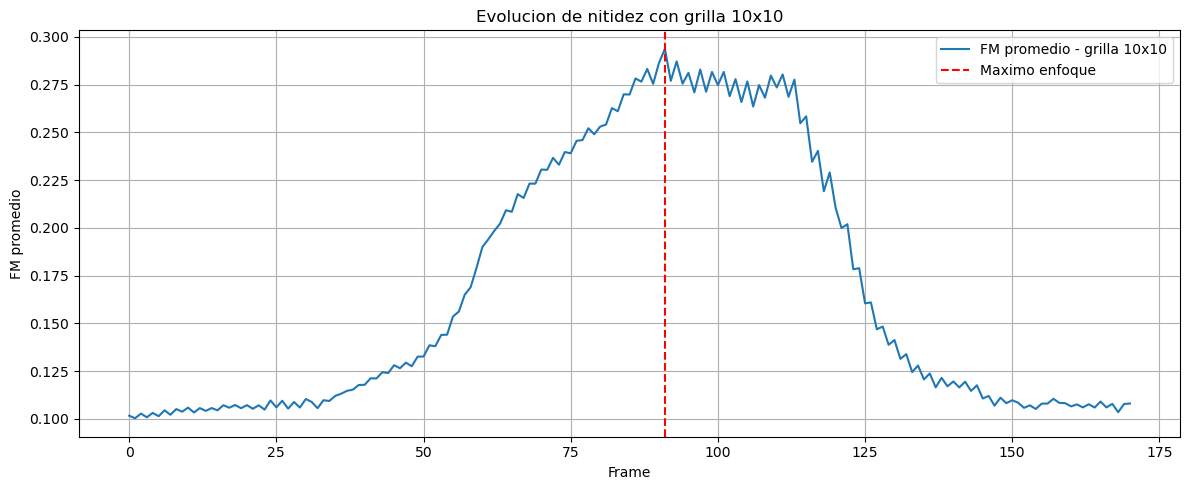

Video generado: output_grilla_10x10.avi


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calcular_lap1(imagen):
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gris, cv2.CV_64F)
    energia = np.sum(np.square(lap))
    return energia

#Funcion para generar la grilla
def dividir_en_grilla(frame, N, M):
    h, w = frame.shape[:2]
    dh, dw = h // N, w // M
    celdas = []
    coords = []
    for i in range(N):
        for j in range(M):
            y1, y2 = i * dh, (i + 1) * dh
            x1, x2 = j * dw, (j + 1) * dw
            celdas.append(frame[y1:y2, x1:x2])
            coords.append(((x1, y1), (x2, y2)))
    return celdas, coords



# Parametros de grilla
N, M = 10, 10 

video = cv2.VideoCapture('focus_video.mov')
fms = []
frames = []

while True:
    ret, frame = video.read()
    if not ret:
        break
    celdas, _ = dividir_en_grilla(frame, N, M)
    fms_frame = [calcular_lap1(celda) for celda in celdas]
    fms.append(np.mean(fms_frame))
    frames.append(frame)

video.release()

# Deteccion de maximo de enfoque
max_index = np.argmax(fms)
print(f"Frame con maximo enfoque en grilla {N}x{M}: {max_index}, LAP1 promedio = {fms[max_index]:.5f}")

# Grafica
plt.figure(figsize=(12, 5))
plt.plot(fms, label=f'LAP1 promedio - grilla {N}x{M}')
plt.axvline(x=max_index, color='r', linestyle='--', label='Maximo enfoque')
plt.xlabel('Frame')
plt.ylabel('LAP1 promedio')
plt.title(f'Evolucion de nitidez con grilla {N}x{M}')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(f"evolucion_enfoque_grilla_{N}x{M}.png")
plt.show()




# Creacion de video con grilla con color segun foco
output = cv2.VideoWriter(
    f'output_grilla_{N}x{M}_LAP1.avi',
    cv2.VideoWriter_fourcc(*'XVID'),
    30,
    (frames[0].shape[1], frames[0].shape[0])
)

for i, frame in enumerate(frames):
    _, coords = dividir_en_grilla(frame, N, M)
    color = (0, 255, 0) if i == max_index else (0, 0, 255)
    for (x1, y1), (x2, y2) in coords:
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, thickness=1)
    output.write(frame)

output.release()
print(f"Video generado: output_grilla_{N}x{M}_LAP1.avi")
